## 卷积神经网络 

* 卷积运算的定义、动机（稀疏权重、参数共享、等变表示）。一维卷积运算和二维卷积运算。
* 反卷积(tf.nn.conv2d_transpose)
* 池化运算的定义、种类（最大池化、平均池化等）、动机。
* 利用CNN模型来识别手写字体。



In [ ]:
'''
卷积运算的定义、动机（稀疏权重、参数共享、等变表示）。一维卷积运算和二维卷积运算。

卷积运算: 与经典的全连接神经网络相比，卷积神经网络运算的原理是通过加入卷积层和池化层，
来对特征进行逐步细化浓缩提取。
实现方式是通过滑动窗口的方式，在原始数据中划分出一个小区域矩阵，
在卷积层conv层与通过窗口filter取前一层特征图上的小区域与下一层神经元做内积和操作(即wx+b)，
经激活函数将线性转为非线性结果，
将结果，即提取的特征点汇到一个特征图，
再通过池化层pooling层 根据求max或mean操作，保留一个特征数，将特征图浓缩，
再经过下一层卷积，池化，逐步浓缩，细化特征，
最后经过两个全连接层整合特征，再softmax把特征分类。
filter在取前一层数据小窗口时，是滑动向前依次提取，
由stride指定每次滑动多远。

稀疏权重：又叫稀疏连接，就是指上面说到的，每次只关注和处理视觉范围前后的影象。
稀疏即散布离散，相对非连续性的一个概念。

参数共享：因为每个特征图小窗口在与下一层神经元做内积和操作进行wx+b操作时都带有一个w,
有多少个神经元就有多少个w，把相同的w共享避免大量操作，这个过程叫参数共享

等变表示: 等比变化，可以通过局部特性按照规律，
映射出整体或其它部分（如通过正脸特征映射画出侧脸）的特征，
反之也可以从整体抽离局部特征浓缩代表整体，等变特性是上面卷积得以实现的依据。

一维卷积运算：比如图象RGB通道，只有一个，灰度图，算上面卷积运算时只对一个平面，
做filter过滤小窗口提取特征，再pooling压缩等操作。

二维护卷积运算：chanel加入一个深度，比如图片识别的特征提取，一张彩色图，
有三个颜色通道RGB，即，输入就是 长X宽X3,3就是深度。
后面对应的filter也是三个分别提取三个通道的特征。

反卷积(tf.nn.conv2d_transpose)：
反卷积操作是卷积的反向，指上面conv pooling 一系列完成得到最终结果后，
反向传播回来求梯度使loss操失最小，来取最合适的参数w,b的操作。

tensorflow的conv2d_transpose函数可以实现反卷积，参数介绍如下：
tf.nn.conv2d_transpose(
value, #输入值，需要反卷积的输入，即从后一层反传回来的梯度值，要求tensor格式
filter, #卷积核，tensor格式，四维[f高，f宽，f个数，chanel深度或图像通道数]
output_shape, #输出的shape
strides, #滑动尺度，每一维滑动的步长
padding="SAME", #边缘填充：滑动窗口到边缘，有空出位补0操作，为了提取完整特征。VALID是舍弃这部分特征。
data_format="NHWC", #输入参数的格式，默认NHWC顺序，即[batch, height, width, in_channels]
)

池化运算的定义、种类（最大池化、平均池化等）、动机。

池化运算: 池化操作是在卷积后面跟着的一层将特征图filter提取的小区域按照规则，
取最大Max或取平均Mean来 保留一个代表性矩阵值。
动机：对特征进一步压缩细化。
这一步和卷积层的实现原理一样，只是没有wx+b 内积和 操作。
最大池化：Max，取前一层特征矩阵中最大值，如[[1,2][4,5]] 只取5放入特征图中。
平均池化：mean,前一层特征矩阵中多个值取平均产，如[[1,2][4,5]] 取 （1+2+4+5）/4 = 6

'''

In [3]:
'''
cnn识别手写字体
'''
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
#初始化tensorflow 读取数据类

In [4]:
#读取minist数据集
mnist = input_data.read_data_sets('MinistData',one_hot=True)
#数据已下载，存在同目录MinistData文件夹下



Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MinistData\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MinistData\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MinistData\t10k-images-idx3-ubyte.gz
Extracting MinistData\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [7]:
print("训练集数据个数：",mnist.train.num_examples)
print("验证集数据个数：",mnist.validation.num_examples)
print("测试集数据个数：",mnist.test.num_examples)

训练集数据个数： 55000
验证集数据个数： 5000
测试集数据个数： 10000


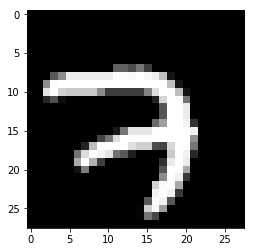

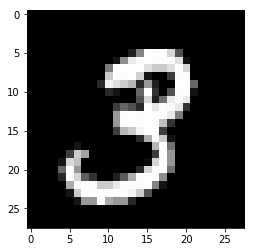

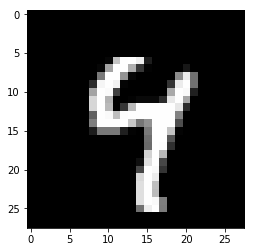

In [39]:
trainDatas = mnist.train.images
trainLabels = mnist.train.labels
testDatas = mnist.test.images
testLabels = mnist.test.labels
#显示图看下
plt.figure()
for i in range(3):
    plt.imshow(trainDatas[i].reshape(28,28),'gray')
    plt.pause(0.0000001)
plt.show()
#更多本数据集操作见
#https://blog.csdn.net/panrenlong/article/details/81736754

In [40]:
#数据初始化
n_input = 784
n_output = 10
#定义两层conv卷积，两层全连接层fc1，fc2
weights = {
    'wc1':tf.Variable(tf.truncated_normal([3,3,1,64],stddev=0.1)),
    'wc2':tf.Variable(tf.truncated_normal([3,3,64,128],stddev=0.1)),
    'wd1':tf.Variable(tf.truncated_normal([7*7*128,1024],stddev=0.1)),
    'wd2':tf.Variable(tf.truncated_normal([1024,n_output],stddev=0.1))
}
#参数解释wc1 [3,3,1,64]#filter的高h,宽w,深度1为灰度图RGB通道一条，输出64个特征图
#wc2[3,3,64,128] #filter高，宽，深64（前一层传过来的64个），输出特征图128个

#定义偏置项
biases = {
    'bc1':tf.Variable(tf.random_normal([64],stddev=0.1)),
    'bc2':tf.Variable(tf.random_normal([128],stddev=0.1)),
    'bd1':tf.Variable(tf.random_normal([1024],stddev=0.1)),
    'bd2':tf.Variable(tf.random_normal([n_output],stddev=0.1))
}

In [41]:
#卷积加池化操作函数
def conv_basic(_input,_w,_b,_keepratio):
    #前向传播
    #数据预处理,将输入的数据变成tensorflow需要的四维格式
    _input_r = tf.reshape(_input,shape=[-1,28,28,1])
    #参数：batchsize，没有的话设1，-1 tf会根据后三项自动算
        #h高度，w宽度，chanel RGB 通道1灰度
    
    #用conv2d进行卷积，代入参数
    _conv1 = tf.nn.conv2d(_input_r,_w['wc1'],strides=[1,1,1,1],padding='SAME')
    #参数：_w['wc1']为上面定义的字典取值第一层w
        #strides 滑动步长 要求四维格式[输入,h,w,chanel]主要 改中间两个h w
        #padding='SAME' 滑到边缘有空值时补0
    
    #给上面卷积层加relu激活函数，转非线性
    _conv1 = tf.nn.relu(tf.nn.bias_add(_conv1,_b['bc1']))
    #relu里面是一个wx+b操作
    
    #加池化层Max-pooling
    _pool1 = tf.nn.max_pool(_conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    #参数：ksize = [1,2,2,1]#2*2窗口
        #strides 滑动步长
    
    #加一层dropout，防过拟和（通过弃用不重要特征的方式）
    _pool_dr1 = tf.nn.dropout(_pool1,_keepratio)
    #_keepratio杀死比例
    
    #再定义一层卷积
    _conv2 = tf.nn.conv2d(_pool_dr1,_w['wc2'],strides=[1,1,1,1],padding='SAME')
    #加relu激活函数
    _conv2 = tf.nn.relu(tf.nn.bias_add(_conv2,_b['bc2']))
    
    #二层池化层
    _pool2 = tf.nn.max_pool(_conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    #加dropout
    _pool_dr2 = tf.nn.dropout(_pool2,_keepratio)
    
    #拼接整理特征图
    _dense1 = tf.reshape(_pool_dr2,[-1,_w['wd1'].get_shape().as_list()[0]])
    #_w['wd1']用上面字典中定义好的骨架
    
    #全连接一层fc1
    _fc1 = tf.nn.relu(tf.add(tf.matmul(_dense1,_w['wd1']),_b['bd1']))
    #与上一层输入x即 _dense1特征图，执行wx+b操作，再relu
    #加dropout
    _fc_dr1 = tf.nn.dropout(_fc1,_keepratio)
                      
    #第二层全连接层fc2，这里用_out表示了
    _out = tf.add(tf.matmul(_fc_dr1,_w['wd2']),_b['bd2'])
    #wx+b,累加
    
    #组合上面信息返回值
    out = {
        'input_r':_input_r,
        'conv1':_conv1,
        'pool1':_pool1,
        'pool_dr1':_pool_dr1,
        'conv2':_conv2,
        'pool2':_pool2,
        'pool_dr2':_pool_dr2,
        'dense1':_dense1,
        'fc1':_fc1,
        'fc_dr1':_fc_dr1,
        'out':_out
    }
    
    return out
    

In [42]:
#处理tf相关操作
a = tf.Variable(tf.random_normal([3,3,1,64],stddev=0.1))
#print(a)
a = tf.Print(a,[a],"a:")
#初始化tf变量
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [44]:
x = tf.placeholder(tf.float32,[None,n_input])
y = tf.placeholder(tf.float32,[None,n_output])
keepratio = tf.placeholder(tf.float32)

_pred = conv_basic(x,weights,biases,keepratio)['out']
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=_pred,labels=y))
#`softmax_cross_entropy_with_logits`参数格式 (labels=..., logits=..., ...)
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
_corr = tf.equal(tf.argmax(_pred,1),tf.argmax(y,1))
#比较预测值与真实例相等则正确
accr = tf.reduce_mean(tf.cast(_corr,tf.float32))

#tf变量初始化
init = tf.global_variables_initializer()


In [49]:
#迭代执行上面函数
sess = tf.Session()
sess.run(init)
training_epochs = 15
batch_size = 16
display_step = 1

for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = 10
    for i in range(total_batch):
        batch_xs,batch_ys = mnist.train.next_batch(batch_size)
        #【训练数据是从这里传进去的，mnist.train 自动划分了x和y】
        sess.run(optm,feed_dict={x:batch_xs,y:batch_ys,keepratio:0.7})
        avg_cost += sess.run(cost,feed_dict={x:batch_xs,y:batch_ys,keepratio:1.})/total_batch
        
    if epoch % display_step == 0:
        print("第 %s 次迭代，共 %s 次，平均损失: %.9f " % (epoch+1,training_epochs,avg_cost))
        train_acc = sess.run(accr,feed_dict={x:batch_xs,y:batch_ys,keepratio:1.})
        print("训练精确度：%.9f" % train_acc)
        #显示小数点位数%.3f 3位，注意前面不是%s.3f
        

第 1 次迭代，共 15 次，平均损失: 5.714303398 
训练精确度：0.125000000
第 2 次迭代，共 15 次，平均损失: 2.583076143 
训练精确度：0.062500000
第 3 次迭代，共 15 次，平均损失: 2.250749660 
训练精确度：0.125000000
第 4 次迭代，共 15 次，平均损失: 2.132968116 
训练精确度：0.500000000
第 5 次迭代，共 15 次，平均损失: 2.019559205 
训练精确度：0.562500000
第 6 次迭代，共 15 次，平均损失: 1.710370076 
训练精确度：0.750000000
第 7 次迭代，共 15 次，平均损失: 1.180212092 
训练精确度：0.750000000
第 8 次迭代，共 15 次，平均损失: 0.928154027 
训练精确度：0.687500000
第 9 次迭代，共 15 次，平均损失: 0.692349124 
训练精确度：0.937500000
第 10 次迭代，共 15 次，平均损失: 0.717520785 
训练精确度：0.812500000
第 11 次迭代，共 15 次，平均损失: 0.619076169 
训练精确度：0.812500000
第 12 次迭代，共 15 次，平均损失: 0.580044615 
训练精确度：0.812500000
第 13 次迭代，共 15 次，平均损失: 0.650347844 
训练精确度：0.937500000
第 14 次迭代，共 15 次，平均损失: 0.590193996 
训练精确度：0.875000000
第 15 次迭代，共 15 次，平均损失: 0.562588316 
训练精确度：0.875000000
